In [16]:
%pip install statsmodels
%pip install patsy


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Jai\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Jai\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [17]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
from sklearn import preprocessing, neighbors, svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns

# df = pd.read_csv('data/2020 Line 280 AVL report.csv')
df = pd.read_csv('data/2019 Line 280 AVL allscripts.csv')
df['Actual Depart Hour'] = df['Actual Depart'].str.split(':',expand=True)[0]
df['Actual Depart Hour'] = df['Actual Depart Hour'].astype(int)
df['Transit Date Month'] = df['Transit Date'].str.split('/',expand=True)[0]
df['Transit Date Month'] = df['Transit Date Month'].astype(int)

Wall time: 1.41 s


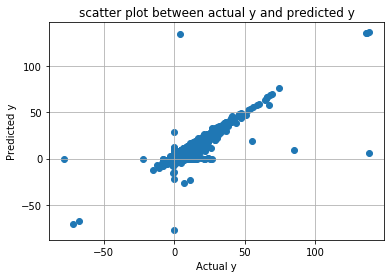

Mean Squared Error : 4.32043060548235
Mean Absolute Error : 0.9685737943886203
[0.90306189 0.75774041 0.84350068 0.78806221 0.92469524]
0.84 accuracy with a standard deviation of 0.06


In [18]:
# df1 = df.copy()
# df1 = df.loc[(df['Bus Stop ID'] == 775) | (df['Bus Stop ID'] == 782) | (df['Bus Stop ID'] == 733)]
df1 = df.loc[(df['Bus Stop ID'] != 177)]
df1 = df1.loc[(df1['Bus Stop ID'] != 738)]
df1 = df1.loc[(df1['Bus Stop ID'] != 2199)]
df1 = df1.loc[(df1['Bus Stop ID'] != 2384)]

df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
    'Miles from Prior Time Point', 'Bus Stop ID'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
        'Enc_Miles_', 'Enc_Stop_'])
# df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
#     'Miles from Prior Time Point'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
#         'Enc_Miles_'])
# df1 = pd.get_dummies(df1, columns=['Transit Date Month'],prefix=['Enc_Month_'])

# df1['Transit Date Month'] = df1['Transit Date'].str.split('/',expand=True)[0]
df1.fillna(value = -9999)
enc = OneHotEncoder(handle_unknown='ignore')

df1['Difference (Minutes)'] = df1['Difference (Minutes)'].astype(int)
df1['Prev Departure Offset'] = df1['Prev Departure Offset'].astype(int)
# df1['Transit Date Month'] = df1['Transit Date Month'].astype(int)

# df.replace('?', -99999, inplace=True) #sees -99999 as outlier, ignores it
df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
    'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
        'Initial Performance Result','Reported Performance Results','Actual Arrival','Waivers',\
            'Dwell Time', 'Actual Run Time', 'Scheduled Operating Speed','Actual Operating Speed',\
                'Run Time Variance','Day Type','Time Period', 'Scheduled Run Time',\
                        'Scheduled Depart DateTime', 'Actual Depart DateTime', \
                            'Same Stop Prev Trip Departure Offset'\
                                ], 1, inplace=True)
# print(df1.head)
# pd.to_numeric(df1['Actual Operating Speed'], errors='coerce')
X = np.array(df1.drop(['Difference (Minutes)'],1)) #using everything except class to train
Y = np.array(df1['Difference (Minutes)']) #class is the final result obviously
np.nan_to_num(X)
np.nan_to_num(Y)
pd.isnull(X)
np.nan_to_num(X)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

# lr_sgd = SGDRegressor(penalty='elasticnet')
lr_sgd = SGDRegressor(loss='huber', penalty='elasticnet')
%time lr_sgd.fit(X_train, Y_train)

filename = 'models/2019_lr_sgd_model_9_15.sav'
pickle.dump(lr_sgd, open(filename, 'wb'))

plt.scatter(Y_test, lr_sgd.predict(X_test))
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print('Mean Squared Error :',mean_squared_error(Y_test, lr_sgd.predict(X_test)))
print('Mean Absolute Error :',mean_absolute_error(Y_test, lr_sgd.predict(X_test)))

scores = cross_val_score(lr_sgd, X_test, Y_test, cv=5)

print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)
# ax.plot(X_train, clf.fit(X_train, Y_train).predict(X_train), lw=2)
# ax.scatter(X_train[clf.support_], Y_train[clf.support_], facecolor="none",s=50)
# # ax.scatter(X_test[np.setdiff1d(np.arange(len(X_test)),clf.support_)],
# #            Y_test[np.setdiff1d(np.arange(len(X_test)), clf.support_)],
# #            facecolor="none", edgecolor="k", s=50)


# fig.text(0.5, 0.04, 'data', ha='center', va='center')
# fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
# fig.suptitle("Support Vector Regression", fontsize=14)
# plt.show()

In [19]:

# df1 = df.copy()
# df1 = df.loc[(df['Bus Stop ID'] == 775) | (df['Bus Stop ID'] == 782) | (df['Bus Stop ID'] == 733)]





#################################################################################
# df1 = df.loc[(df['Bus Stop ID'] != 177)]
# df1 = df1.loc[(df1['Bus Stop ID'] != 738)]
# df1 = df1.loc[(df1['Bus Stop ID'] != 2199)]
# df1 = df1.loc[(df1['Bus Stop ID'] != 2384)]

# df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
#     'Miles from Prior Time Point', 'Bus Stop ID'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
#         'Enc_Miles_', 'Enc_Stop_'])
# # df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week', \
# #     'Miles from Prior Time Point'],prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_',\
# #         'Enc_Miles_'])
# # df1 = pd.get_dummies(df1, columns=['Transit Date Month'],prefix=['Enc_Month_'])

# # df1['Transit Date Month'] = df1['Transit Date'].str.split('/',expand=True)[0]
# df1.fillna(value = -9999)
# enc = OneHotEncoder(handle_unknown='ignore')

# df1['Difference (Minutes)'] = df1['Difference (Minutes)'].astype(int)
# df1['Prev Departure Offset'] = df1['Prev Departure Offset'].astype(int)
# # df1['Transit Date Month'] = df1['Transit Date Month'].astype(int)

# # df.replace('?', -99999, inplace=True) #sees -99999 as outlier, ignores it
# df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
#     'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
#         'Initial Performance Result','Reported Performance Results','Actual Arrival','Waivers',\
#             'Dwell Time', 'Actual Run Time', 'Scheduled Operating Speed','Actual Operating Speed',\
#                 'Run Time Variance','Day Type','Time Period', 'Scheduled Run Time',\
#                         'Scheduled Depart DateTime', 'Actual Depart DateTime', \
#                             'Same Stop Prev Trip Departure Offset'\
#                                 ], 1, inplace=True)
# print(df1.head)
# # pd.to_numeric(df1['Actual Operating Speed'], errors='coerce')
# X = np.array(df1.drop(['Difference (Minutes)'],1)) #using everything except class to train
# Y = np.array(df1['Difference (Minutes)']) #class is the final result obviously
# np.nan_to_num(X)
# np.nan_to_num(Y)
# pd.isnull(X)
# np.nan_to_num(X)

# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

# clf = svm.SVR()
# %time clf.fit(X_train, Y_train)

# scores = cross_val_score(clf, X_test, Y_test, cv=5)

# print(scores)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
#################################################################################





# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)
# ax.plot(X_train, clf.fit(X_train, Y_train).predict(X_train), lw=2)
# ax.scatter(X_train[clf.support_], Y_train[clf.support_], facecolor="none",s=50)
# # ax.scatter(X_test[np.setdiff1d(np.arange(len(X_test)),clf.support_)],
# #            Y_test[np.setdiff1d(np.arange(len(X_test)), clf.support_)],
# #            facecolor="none", edgecolor="k", s=50)


# fig.text(0.5, 0.04, 'data', ha='center', va='center')
# fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
# fig.suptitle("Support Vector Regression", fontsize=14)
# plt.show()

<bound method NDFrame.head of         Scheduled Run Time  Actual Run Time  Enc_Hour__0  Enc_Hour__1  \
0                        0                0            0            0   
1                        8                6            0            0   
2                        6                6            0            0   
3                        9               10            0            0   
4                        0                6            0            0   
...                    ...              ...          ...          ...   
202608                   0                0            0            0   
202609                   9                9            0            0   
202610                   0               10            0            0   
202611                   0                3            0            0   
202612                   0                6            0            0   

        Enc_Hour__5  Enc_Hour__6  Enc_Hour__7  Enc_Hour__8  Enc_Hour__9  \
0                 

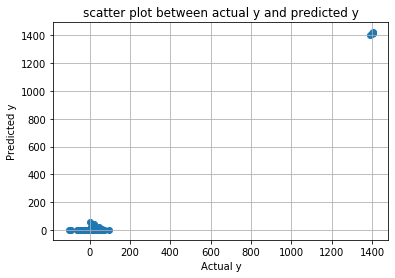

Mean Squared Error : 30.548329558220843
Mean Absolute Error : 2.792606639117415
[ 0.88491113 -0.01549033  0.88597015  0.94262547  0.96985855]
0.73 accuracy with a standard deviation of 0.38


In [20]:
df1 = df.copy()


df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week']\
    ,prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_'])

df1.fillna(value = -9999)
enc = OneHotEncoder(handle_unknown='ignore')

df1['Scheduled Run Time'] = df1['Scheduled Run Time'].astype(int)
df1['Actual Run Time'] = df1['Actual Run Time'].astype(int)

df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
    'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
   'Miles from Prior Time Point', 'Bus Stop ID',
        'Initial Performance Result','Reported Performance Results','Actual Arrival','Waivers',\
            'Dwell Time', 'Scheduled Operating Speed','Actual Operating Speed',\
                'Run Time Variance','Day Type','Time Period',\
                        'Scheduled Depart DateTime', 'Actual Depart DateTime', \
                            'Same Stop Prev Trip Departure Offset', \
                                'Difference (Minutes)', 'Prev Departure Offset'], 1, inplace=True)
print(df1.head)
X = np.array(df1.drop(['Actual Run Time'],1)) #using everything except class to train
Y = np.array(df1['Actual Run Time']) #class is the final result obviously
np.nan_to_num(X)
np.nan_to_num(Y)
pd.isnull(X)
np.nan_to_num(X)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

lr_sgd = SGDRegressor(loss='huber')
%time lr_sgd.fit(X_train, Y_train)

filename = 'models/2019_lr_sgd_model_9_15.sav'
pickle.dump(lr_sgd, open(filename, 'wb'))

plt.scatter(Y_test, lr_sgd.predict(X_test))
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print('Mean Squared Error :',mean_squared_error(Y_test, lr_sgd.predict(X_test)))
print('Mean Absolute Error :',mean_absolute_error(Y_test, lr_sgd.predict(X_test)))

scores = cross_val_score(lr_sgd, X_test, Y_test, cv=5)

print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4), sharey=True)
# ax.plot(X_train, clf.fit(X_train, Y_train).predict(X_train), lw=2)
# ax.scatter(X_train[clf.support_], Y_train[clf.support_], facecolor="none",s=50)
# # ax.scatter(X_test[np.setdiff1d(np.arange(len(X_test)),clf.support_)],
# #            Y_test[np.setdiff1d(np.arange(len(X_test)), clf.support_)],
# #            facecolor="none", edgecolor="k", s=50)


# fig.text(0.5, 0.04, 'data', ha='center', va='center')
# fig.text(0.06, 0.5, 'target', ha='center', va='center', rotation='vertical')
# fig.suptitle("Support Vector Regression", fontsize=14)
# plt.show()

No handles with labels found to put in legend.


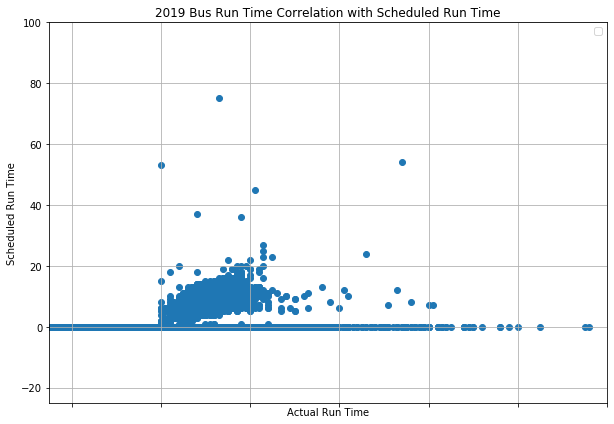

0.9794987697434454

In [21]:
stopactual = df
stopactual['Actual Run Time'] = stopactual['Actual Run Time'].astype(int)
stopactual['Scheduled Run Time'] = stopactual['Scheduled Run Time'].astype(int)

f=plt.figure(figsize=(10,7))

ax1=f.add_subplot(111)
ax1.set_xlim(left = -25,right=100)
ax1.set_ylim(bottom=-25,top=100)
ax1.set(Title="2019 Bus Run Time Correlation with Scheduled Run Time")
# plt.ylim(0,15)
ax1.scatter(stopactual['Actual Run Time'], stopactual['Scheduled Run Time'])
plt.setp(ax1.get_xticklabels(), visible=False)
plt.legend()
plt.grid()

ax1.set(xlabel="Actual Run Time")
ax1.set(ylabel="Scheduled Run Time")

locs, labels = plt.xticks() 



plt.show()

df['Actual Run Time'].corr(df['Scheduled Run Time'])

In [22]:
print(df.loc[df['Run Time Variance']==0].shape[0]/df.shape[0])

0.4404011588595006


Wall time: 767 ms


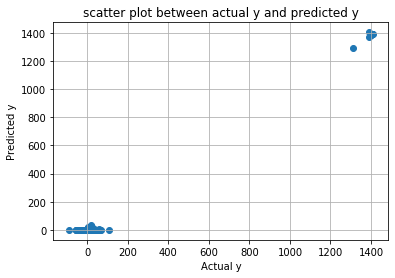

Mean Squared Error : 30.13453802070759
Mean Absolute Error : 2.767812672976575
[0.97529349 0.93910756 0.94245244 0.88338639 0.97647501]
0.94 accuracy with a standard deviation of 0.03


In [23]:
df1 = df.copy()


df1 = pd.get_dummies(df1, columns=['Actual Depart Hour', 'Transit Date Month', 'Day of Week']\
    ,prefix=['Enc_Hour_', 'Enc_Month_', 'Enc_Day_'])

df1.fillna(value = -9999)
enc = OneHotEncoder(handle_unknown='ignore')

df1['Scheduled Run Time'] = df1['Scheduled Run Time'].astype(int)
df1['Actual Run Time'] = df1['Actual Run Time'].astype(int)

df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
    'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
   'Miles from Prior Time Point', 'Bus Stop ID',
        'Initial Performance Result','Reported Performance Results','Actual Arrival','Waivers',\
            'Dwell Time', 'Scheduled Operating Speed','Actual Operating Speed',\
                'Run Time Variance','Day Type','Time Period',\
                        'Scheduled Depart DateTime', 'Actual Depart DateTime', \
                            'Same Stop Prev Trip Departure Offset', \
                                'Difference (Minutes)', 'Prev Departure Offset'], 1, inplace=True)
X = np.array(df1.drop(['Actual Run Time'],1)) #using everything except class to train
Y = np.array(df1['Actual Run Time']) #class is the final result obviously
np.nan_to_num(X)
np.nan_to_num(Y)
pd.isnull(X)
np.nan_to_num(X)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

lr_sgd = SGDRegressor(loss='huber')
%time lr_sgd.fit(X_train, Y_train)



plt.scatter(Y_test, lr_sgd.predict(X_test))
plt.grid()
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('scatter plot between actual y and predicted y')
plt.show()
print('Mean Squared Error :',mean_squared_error(Y_test, lr_sgd.predict(X_test)))
print('Mean Absolute Error :',mean_absolute_error(Y_test, lr_sgd.predict(X_test)))

scores = cross_val_score(lr_sgd, X_test, Y_test, cv=5)
print(scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [24]:
df1 = df.copy()
df1.fillna(value = -999999)
df1['Actual Run Time'] = df1['Actual Run Time'].astype(float)
df1['Scheduled Run Time'] = df1['Scheduled Run Time'].astype(float)


df1.drop(['Transit Date', 'Vehicle #', 'Block #', 'Route #', 'Trip #', 'Direction',\
    'Pattern','Bus Stop Name', 'Stop Sequence','Latitude','Longitude','Scheduled Depart','Actual Depart',\
   'Miles from Prior Time Point',
        'Initial Performance Result','Reported Performance Results','Actual Arrival','Waivers',\
            'Dwell Time', 'Scheduled Operating Speed','Actual Operating Speed',\
                'Run Time Variance','Day Type','Time Period',\
                        'Scheduled Depart DateTime', 'Actual Depart DateTime', \
                            'Same Stop Prev Trip Departure Offset', \
                                'Difference (Minutes)', 'Prev Departure Offset'], 1, inplace=True)

train=df1.sample(frac=0.8)
test=df1.drop(train.index)
# X_test = np.array(test.drop(['Actual Run Time'],1))
# Y_test = np.array(test['Actual Run Time'])

model = smf.mixedlm('Q("Actual Run Time") ~ Q("Scheduled Run Time") + C(Q("Actual Depart Hour")) + C(Q("Transit Date Month")) + C(Q("Day of Week"))',data = train,groups = "Bus Stop ID").fit()
# print(model.summary())
test['Predicted Actual Run Time'] = model.predict(test)
test['Predict = Actual'] = test['Actual Run Time'] == test['Predicted Actual Run Time']

test['Predicted Error'] = abs(test['Actual Run Time']-test['Predicted Actual Run Time'])/test[['Actual Run Time', 'Predicted Actual Run Time']].max(axis=1)
print(test.head())

    Bus Stop ID  Scheduled Run Time  Actual Run Time Day of Week  \
0           738                 0.0              0.0   Wednesday   
2           782                 6.0              6.0   Wednesday   
4           733                 0.0              6.0   Wednesday   
11          738                 0.0              0.0    Thursday   
12          744                 9.0              7.0    Thursday   

    Actual Depart Hour  Transit Date Month  Predicted Actual Run Time  \
0                    7                   1                   3.316141   
2                    7                   1                   9.319120   
4                    7                   1                   3.316141   
11                   7                   1                   3.461565   
12                   7                   1                  12.466034   

    Predict = Actual  Predicted Error  
0              False         1.000000  
2              False         0.356162  
4              False         0.4

Text(0.5, 0, 'Residuals')

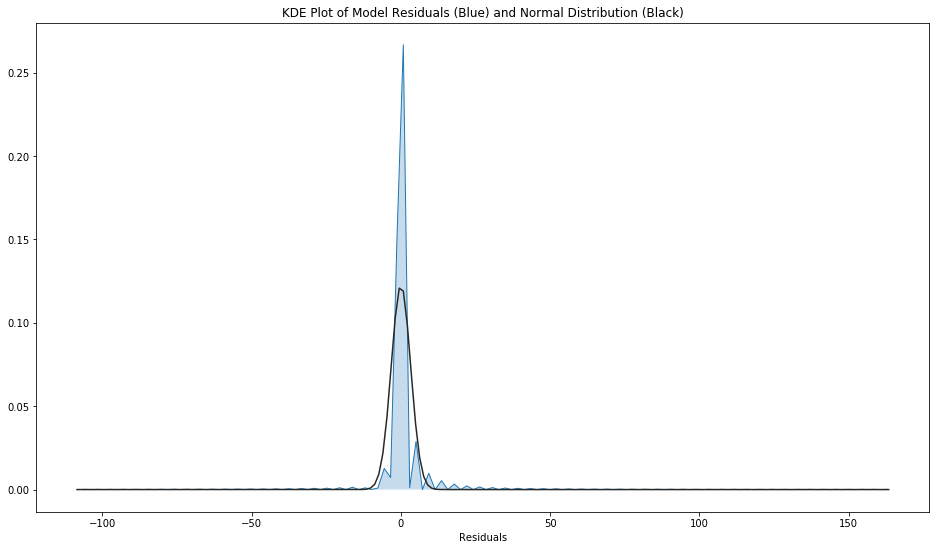

In [25]:
fig = plt.figure(figsize = (16, 9))

ax = sns.distplot(model.resid, hist = False, kde_kws = {"shade" : True, "lw": 1}, fit = stats.norm)

ax.set_title("KDE Plot of Model Residuals (Blue) and Normal Distribution (Black)")
ax.set_xlabel("Residuals")

Text(0.5, 1.0, 'Q-Q Plot')

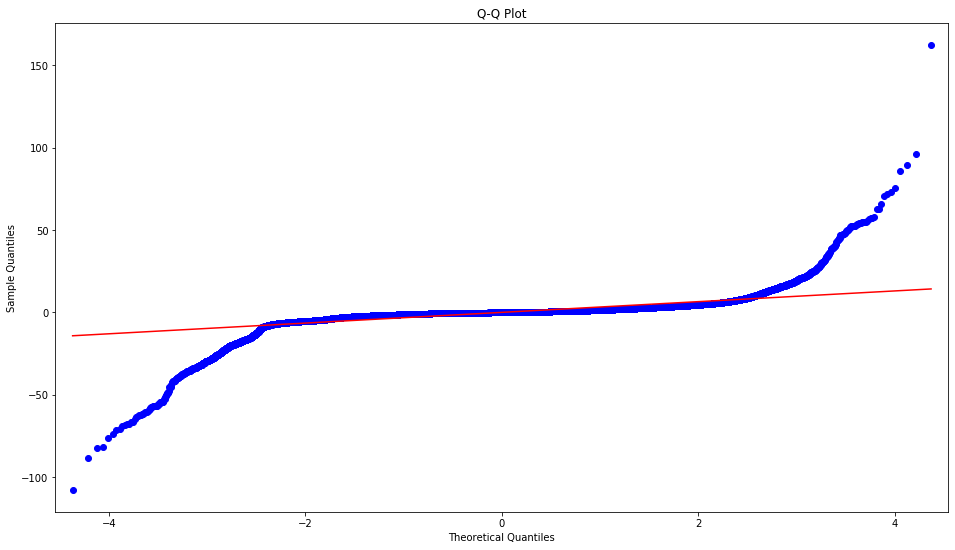

In [26]:
fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

sm.qqplot(model.resid, dist = stats.norm, line = 's', ax = ax)

ax.set_title("Q-Q Plot")

Text(0, 0.5, 'Residuals')

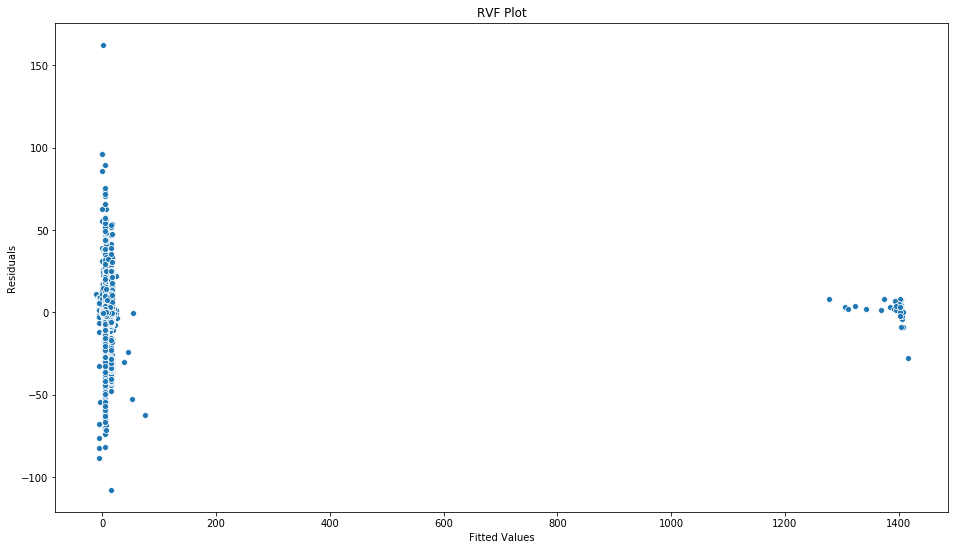

In [27]:
fig = plt.figure(figsize = (16, 9))

ax = sns.scatterplot(y = model.resid, x = model.fittedvalues)

ax.set_title("RVF Plot")
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")

Text(0.5, 0, 'Bus Stop ID')

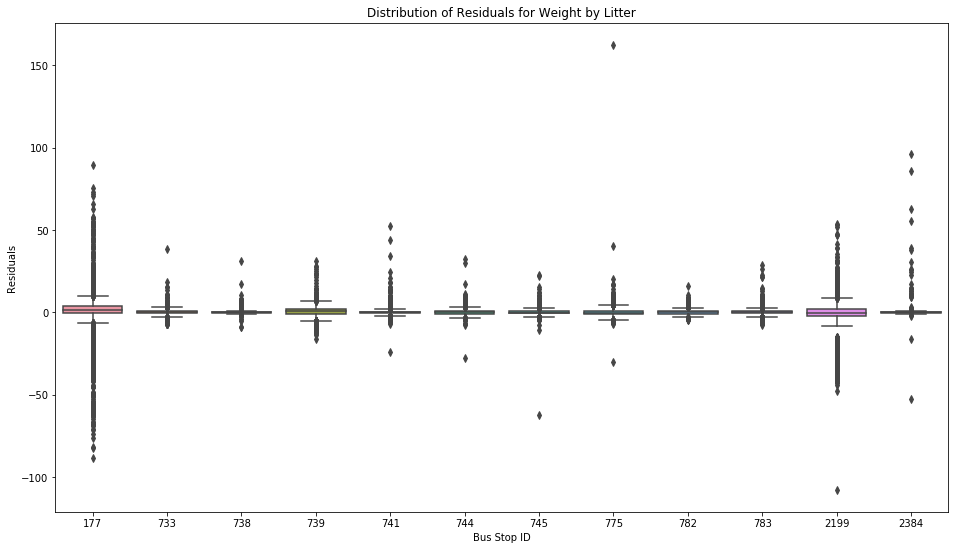

In [28]:
fig = plt.figure(figsize = (16, 9))

ax = sns.boxplot(x = model.model.groups, y = model.resid)

ax.set_title("Distribution of Residuals for Weight by Litter")
ax.set_ylabel("Residuals")
ax.set_xlabel("Bus Stop ID")